# Credit Card Fraud Detection

## The Data   

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.   
Can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

## The goal of the Project

For this project, we'll use everything we've learned about Data Science and Machine Learning thus far to source a dataset, preprocess and explore it, and then build and interpret a classification model that answers your chosen question.

Our goal is to predict if a transaction was fraudulent or not.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Defining functions we will be using for our reports later

In [2]:
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [3]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [4]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [5]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#     return opt

### Data preparation

In [6]:
df = pd.read_csv('creditcard.csv')

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.shape

(284807, 31)

## Split to train and test sets (not normalised data)

In [9]:
y = df['Class']
X = df.drop(columns=['Class'], axis=1)

In [10]:
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Data Shapes:")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | y_train {y_train.shape} | y_test {y_test.shape}")

Data Shapes:
X_train: (199364, 30) | X_test: (85443, 30) | y_train (199364,) | y_test (85443,)


In [12]:
print(f"Number of Frauds in Train Set: {y_train.sum()}")
print(f"Number of Frauds in Test Set: {y_test.sum()}")

Number of Frauds in Train Set: 356
Number of Frauds in Test Set: 136


## Split the train set to train and validation sets

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
print(f"X_train: {X_train.shape} | X_val: {X_val.shape} | y_train {y_train.shape} | y_val {y_val.shape}")

X_train: (139554, 30) | X_val: (59810, 30) | y_train (139554,) | y_val (59810,)


In [14]:
print(f"Number of Frauds in Train: {y_train.sum()}")
print(f"Number of Frauds in Validation: {y_val.sum()}")

Number of Frauds in Train: 258
Number of Frauds in Validation: 98


In [15]:
# Training set
print(y_train.value_counts())
print('\n')
# Validation set
print(y_val.value_counts())

0    139296
1       258
Name: Class, dtype: int64


0    59712
1       98
Name: Class, dtype: int64


## Scaling

As the data description says, all our features have been PCA transformed except 'Time' and 'Amount'. So we are scaling only these two columns:

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df.Amount = scaler.fit_transform((df.Amount).values.reshape(-1,1))
df.Time = scaler.fit_transform((df.Time).values.reshape(-1,1))

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## SMOTE

I'm going to use the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.   


0    139296
1       258
Name: Class, dtype: int64


1    139296
0    139296
dtype: int64


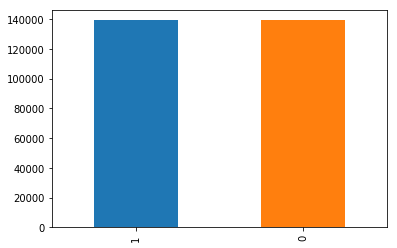

In [17]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, y_train = SMOTE().fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train).value_counts()) 

# observe that data has been balanced
pd.Series(y_train).value_counts().plot.bar()

# Modelling

## Decision Trees

In [18]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

train: 1.0 test: 0.89


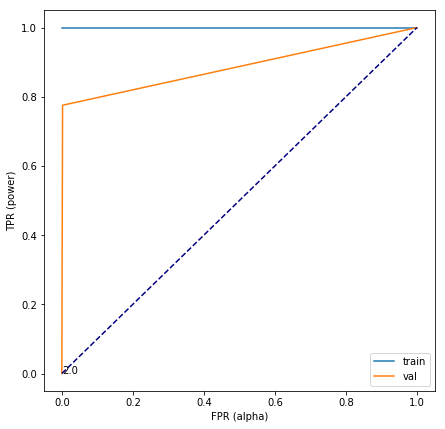

In [19]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

### Grid Search CV with Decision Trees

In [20]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42)

train: 1.0 test: 0.93
{'max_depth': 20, 'min_samples_leaf': 50}
CPU times: user 33.1 s, sys: 374 ms, total: 33.5 s
Wall time: 4min 22s


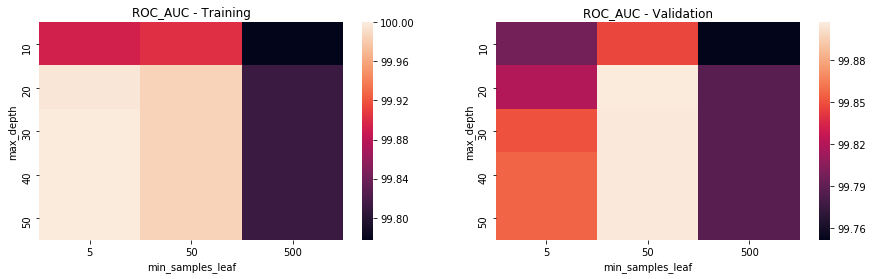

In [21]:
%%time
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 1.0 test: 0.93


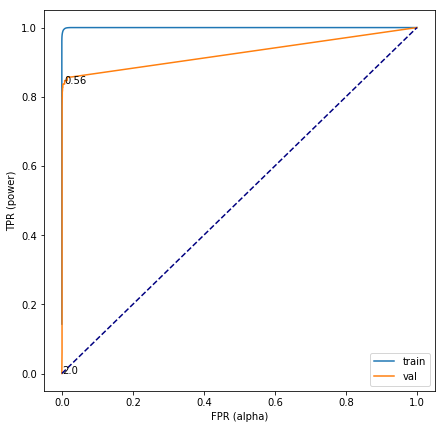

In [22]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 1.0 test: 0.94
{'max_depth': 20, 'min_samples_leaf': 100}
CPU times: user 1min 7s, sys: 622 ms, total: 1min 7s
Wall time: 19min 8s


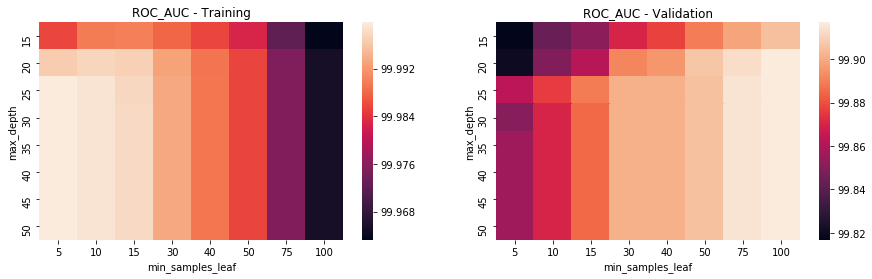

In [23]:
%%time
param_grid = {'max_depth':range(15,50+1,5),'min_samples_leaf':[5,10,15,30,40,50,75,100]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 1.0 test: 0.92


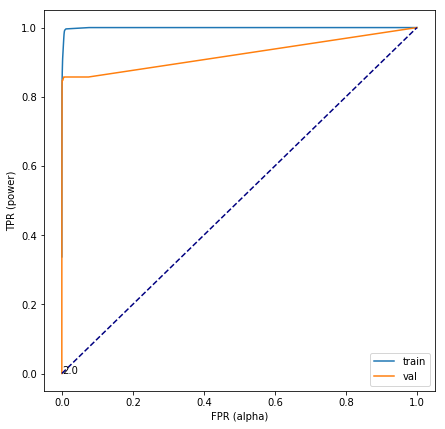

In [22]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.99 test: 0.89
{'max_depth': 18, 'min_samples_leaf': 28}
CPU times: user 1min 54s, sys: 1.2 s, total: 1min 55s
Wall time: 37min 21s


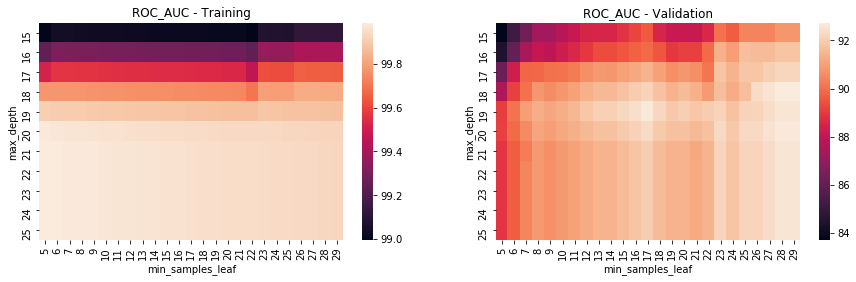

In [23]:
%%time
param_grid = {'max_depth':range(15,25+1),'min_samples_leaf':range(5,30, 5)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.99 test: 0.89


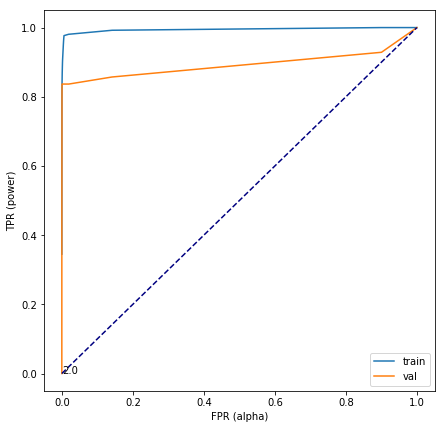

In [24]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [25]:
best_tree = best_model

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=42)
model.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

train: 1.0 test: 0.94


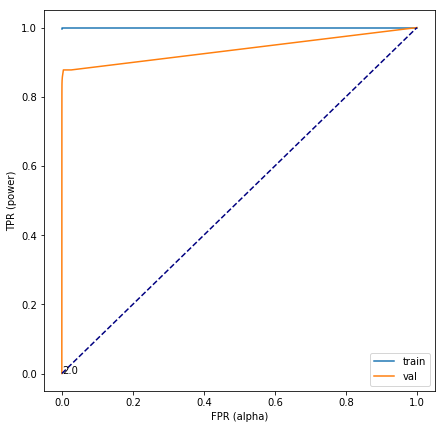

In [25]:
# Even off-the-shelf is better!!
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

### Grid Search CV with Random Forest

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] max_depth=1, min_samples_leaf=50 ................................
[CV] max_depth=1, min_samples_leaf=50 ................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.8844718095974377, total=   0.8s
[CV]  max_depth=1, min_samples_leaf=5, score=0.8937285837748883, total=   0.9s
[CV] max_depth=1, min_samples_leaf=50 ................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.9515741356887844, total=   0.9s


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s


[CV]  max_depth=1, min_samples_leaf=5, score=0.9016370251033038, total=   1.0s
[CV]  max_depth=1, min_samples_leaf=5, score=0.8915614273276703, total=   0.9s
[CV] max_depth=1, min_samples_leaf=50 ................................
[CV] max_depth=1, min_samples_leaf=50 ................................
[CV]  max_depth=1, min_samples_leaf=50, score=0.8844041636755204, total=   0.8s
[CV] max_depth=1, min_samples_leaf=500 ...............................
[CV]  max_depth=1, min_samples_leaf=50, score=0.8934938854175006, total=   0.7s
[CV]  max_depth=1, min_samples_leaf=50, score=0.9515741356887844, total=   0.6s
[CV] max_depth=1, min_samples_leaf=500 ...............................
[CV] max_depth=1, min_samples_leaf=500 ...............................
[CV]  max_depth=1, min_samples_leaf=50, score=0.9013266385559213, total=   0.6s
[CV] max_depth=1, min_samples_leaf=500 ...............................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s


[CV]  max_depth=1, min_samples_leaf=50, score=0.8915614273276703, total=   0.8s
[CV]  max_depth=1, min_samples_leaf=500, score=0.900897343862168, total=   0.7s
[CV] max_depth=1, min_samples_leaf=500 ...............................
[CV]  max_depth=1, min_samples_leaf=500, score=0.9004809935747873, total=   0.5s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV]  max_depth=1, min_samples_leaf=500, score=0.9596915925526069, total=   0.6s
[CV]  max_depth=1, min_samples_leaf=500, score=0.9291780246324453, total=   0.6s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV]  max_depth=1, min_samples_leaf=500, score=0.8989265974525781, total=   0.5s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV] max_depth=11, min_samples_leaf=50 ...............................
[CV] max_depth=11, 

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.6s


[CV] max_depth=11, min_samples_leaf=500 ..............................
[CV]  max_depth=11, min_samples_leaf=5, score=0.9859970622370775, total=   9.1s
[CV]  max_depth=11, min_samples_leaf=50, score=0.9589337484123917, total=   8.4s
[CV]  max_depth=11, min_samples_leaf=5, score=0.9319852281341123, total=   8.9s
[CV] max_depth=11, min_samples_leaf=500 ..............................
[CV] max_depth=11, min_samples_leaf=500 ..............................
[CV]  max_depth=11, min_samples_leaf=50, score=0.9311995571103937, total=   8.6s
[CV]  max_depth=11, min_samples_leaf=50, score=0.9707517526444984, total=   8.2s
[CV] max_depth=11, min_samples_leaf=500 ..............................
[CV] max_depth=11, min_samples_leaf=500 ..............................
[CV] max_depth=21, min_samples_leaf=5 ................................
[CV]  max_depth=11, min_samples_leaf=500, score=0.9682340272792536, total=   7.4s
[CV] max_depth=21, min_samples_leaf=5 ................................
[CV]  max_depth=11

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.7s


[CV]  max_depth=11, min_samples_leaf=50, score=0.9630340883257357, total=   9.1s
[CV]  max_depth=11, min_samples_leaf=500, score=0.9340535581651559, total=   8.5s
[CV]  max_depth=11, min_samples_leaf=50, score=0.9646469018706948, total=   9.1s
[CV] max_depth=21, min_samples_leaf=5 ................................
[CV]  max_depth=11, min_samples_leaf=500, score=0.956570517219415, total=   7.4s
[CV] max_depth=21, min_samples_leaf=5 ................................
[CV] max_depth=21, min_samples_leaf=50 ...............................
[CV] max_depth=21, min_samples_leaf=50 ...............................
[CV] max_depth=21, min_samples_leaf=50 ...............................
[CV]  max_depth=21, min_samples_leaf=5, score=0.9215321111049755, total=  10.4s
[CV] max_depth=21, min_samples_leaf=50 ...............................
[CV]  max_depth=21, min_samples_leaf=50, score=0.9439287785079241, total=  11.1s
[CV] max_depth=21, min_samples_leaf=50 ...............................
[CV]  max_depth=2

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.1s


[CV] max_depth=21, min_samples_leaf=500 ..............................
[CV]  max_depth=21, min_samples_leaf=50, score=0.9240536824172274, total=  11.6s
[CV] max_depth=21, min_samples_leaf=500 ..............................
[CV]  max_depth=21, min_samples_leaf=5, score=0.944146961343854, total=  13.0s
[CV] max_depth=21, min_samples_leaf=500 ..............................
[CV] max_depth=31, min_samples_leaf=5 ................................
[CV]  max_depth=21, min_samples_leaf=50, score=0.973559429874107, total=  12.0s
[CV] max_depth=31, min_samples_leaf=5 ................................
[CV]  max_depth=21, min_samples_leaf=500, score=0.9685984869401956, total=   7.7s
[CV] max_depth=31, min_samples_leaf=5 ................................
[CV]  max_depth=21, min_samples_leaf=500, score=0.9699382534879776, total=   8.3s
[CV] max_depth=31, min_samples_leaf=5 ................................
[CV]  max_depth=21, min_samples_leaf=500, score=0.9632921414706476, total=   8.9s
[CV] max_depth=31

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.2s


[CV] max_depth=31, min_samples_leaf=50 ...............................
[CV]  max_depth=31, min_samples_leaf=5, score=0.9215321111049755, total=  10.8s
[CV] max_depth=31, min_samples_leaf=50 ...............................
[CV]  max_depth=31, min_samples_leaf=5, score=0.8925996156469252, total=  15.0s
[CV] max_depth=31, min_samples_leaf=50 ...............................
[CV]  max_depth=31, min_samples_leaf=5, score=0.9604681679998454, total=  12.1s
[CV] max_depth=31, min_samples_leaf=500 ..............................
[CV]  max_depth=31, min_samples_leaf=50, score=0.9439287785079241, total=  10.8s
[CV] max_depth=31, min_samples_leaf=500 ..............................
[CV]  max_depth=31, min_samples_leaf=5, score=0.9296626077115221, total=  11.8s
[CV] max_depth=31, min_samples_leaf=500 ..............................
[CV]  max_depth=31, min_samples_leaf=50, score=0.9564644901385272, total=  11.1s
[CV] max_depth=31, min_samples_leaf=500 ..............................
[CV]  max_depth=31, m

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min


[CV]  max_depth=31, min_samples_leaf=500, score=0.9699382534879776, total=   8.0s
[CV]  max_depth=31, min_samples_leaf=500, score=0.9445884081100707, total=   9.3s
[CV]  max_depth=31, min_samples_leaf=500, score=0.9632921414706475, total=   8.5s
[CV] max_depth=41, min_samples_leaf=5 ................................
[CV] max_depth=41, min_samples_leaf=50 ...............................
[CV] max_depth=41, min_samples_leaf=50 ...............................
[CV]  max_depth=31, min_samples_leaf=500, score=0.9559954927087314, total=   8.0s
[CV] max_depth=41, min_samples_leaf=50 ...............................
[CV]  max_depth=41, min_samples_leaf=5, score=0.9215321111049755, total=  10.7s
[CV] max_depth=41, min_samples_leaf=50 ...............................
[CV]  max_depth=41, min_samples_leaf=5, score=0.9604681679998454, total=  12.0s
[CV] max_depth=41, min_samples_leaf=50 ...............................
[CV]  max_depth=41, min_samples_leaf=5, score=0.8925996156469252, total=  13.6s
[CV] m

[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  1.3min remaining:    7.9s


[CV]  max_depth=41, min_samples_leaf=50, score=0.973559429874107, total=  11.0s
[CV]  max_depth=41, min_samples_leaf=500, score=0.9685984869401956, total=   6.1s
[CV]  max_depth=41, min_samples_leaf=50, score=0.9539811473604121, total=   7.4s
[CV]  max_depth=41, min_samples_leaf=500, score=0.9699382534879776, total=   5.3s
[CV]  max_depth=41, min_samples_leaf=500, score=0.9632921414706476, total=   5.5s
[CV]  max_depth=41, min_samples_leaf=500, score=0.9445884081100708, total=   6.6s
[CV]  max_depth=41, min_samples_leaf=500, score=0.9559954927087316, total=   4.6s


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.4min finished


train: 0.99 test: 0.98
{'max_depth': 21, 'min_samples_leaf': 500}
CPU times: user 14.7 s, sys: 311 ms, total: 15.1 s
Wall time: 1min 23s


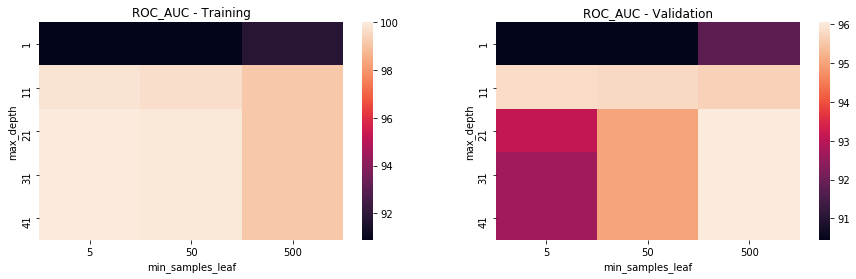

In [28]:
%%time
param_grid = {'max_depth':range(1,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=10)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.99 test: 0.98


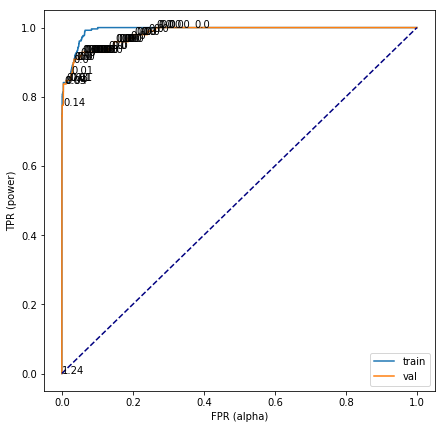

In [29]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 1.0 test: 0.97
{'max_depth': 15, 'min_samples_leaf': 40}
CPU times: user 36.1 s, sys: 463 ms, total: 36.5 s
Wall time: 7min 38s


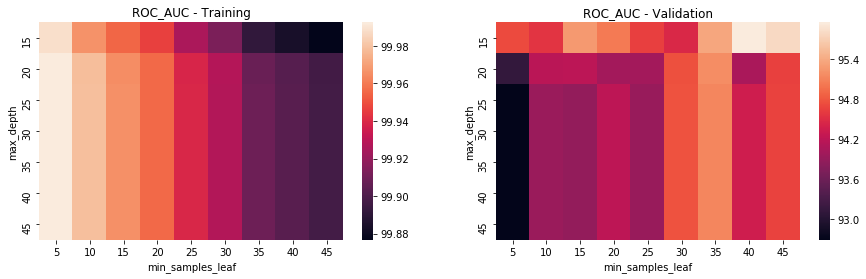

In [30]:
%%time
param_grid = {'max_depth':range(15,45+1,5),'min_samples_leaf':range(5,45+1,5)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 1.0 test: 0.97


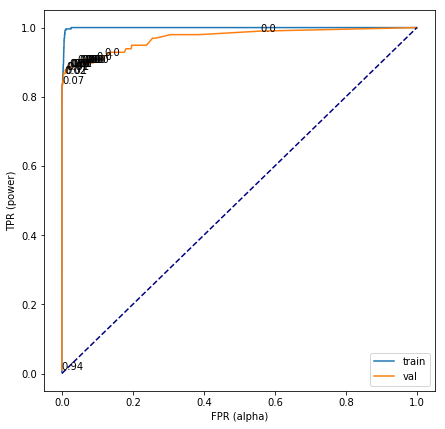

In [31]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 1.0 test: 0.94
{'max_depth': 20, 'min_samples_leaf': 6}
CPU times: user 1min 32s, sys: 1.1 s, total: 1min 33s
Wall time: 25min 46s


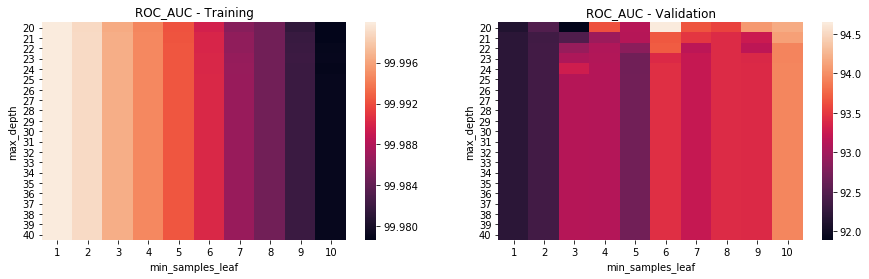

In [32]:
%%time
param_grid = {'max_depth':range(20,40+1,1),'min_samples_leaf':range(1,10+1)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 1.0 test: 0.94


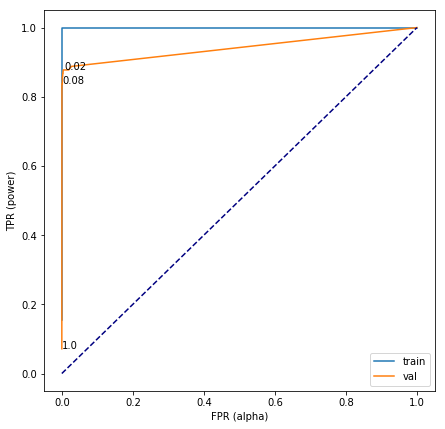

In [33]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 1.0 test: 0.95
{'max_depth': 15, 'min_samples_leaf': 4}
CPU times: user 36.8 s, sys: 473 ms, total: 37.2 s
Wall time: 7min 46s


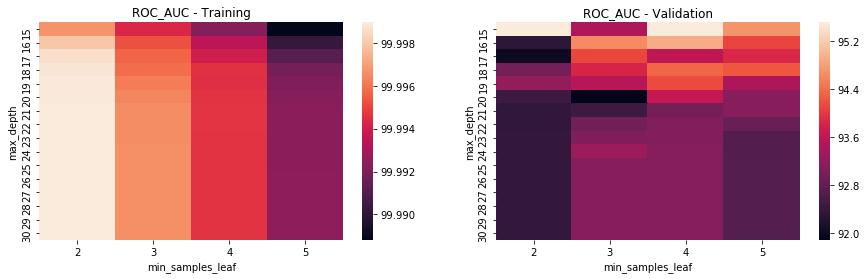

In [34]:
%%time
param_grid = {'max_depth':range(15,30+1),'min_samples_leaf':range(2,5+1)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 1.0 test: 0.95


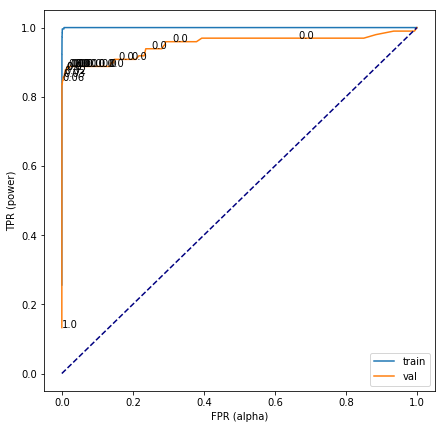

In [35]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [36]:
best_forest = best_model

## AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(DecisionTreeClassifier(),random_state=42)
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42)

train: 1.0 test: 0.89


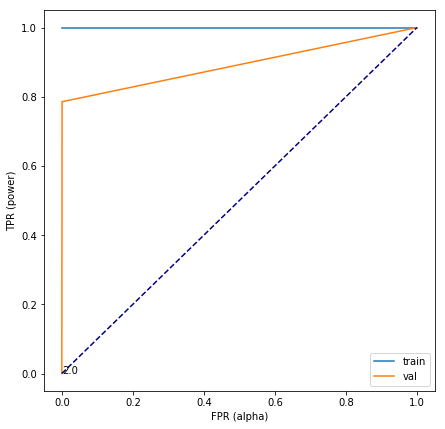

In [38]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

### Grid Search CV with AdaBoost

In [39]:
param_grid = {'learning_rate':[lr/100 for lr in range(1,100+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)

train: 1.0 test: 0.89
{'learning_rate': 0.01}


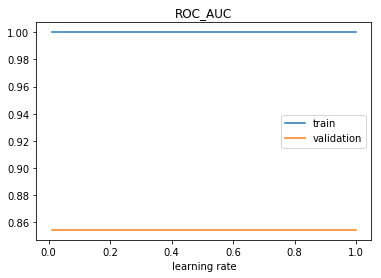

In [40]:
opt = pd.DataFrame(opt_model.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params,opt[cols]],axis=1,sort=False)
plt.plot(opt['learning_rate'],opt['mean_train_score'])
plt.plot(opt['learning_rate'],opt['mean_test_score'])
plt.title('ROC_AUC')
plt.xlabel('learning rate')
plt.legend(['train','validation'])

In [41]:
param_grid = {'learning_rate':[lr for lr in range(1,10+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)

train: 1.0 test: 0.89
{'learning_rate': 1}


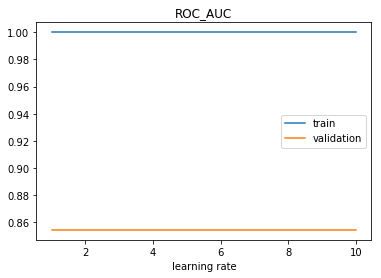

In [42]:
opt = pd.DataFrame(opt_model.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params,opt[cols]],axis=1,sort=False)
plt.plot(opt['learning_rate'],opt['mean_train_score'])
plt.plot(opt['learning_rate'],opt['mean_test_score'])
plt.title('ROC_AUC')
plt.xlabel('learning rate')
plt.legend(['train','validation'])

train: 1.0 test: 0.89


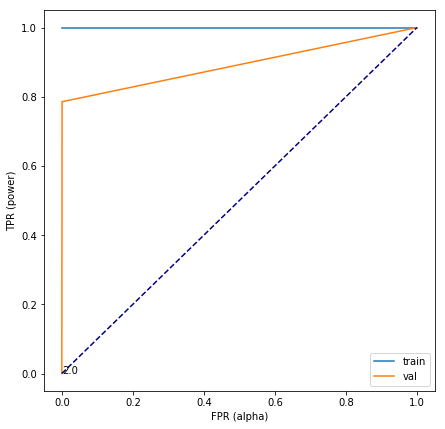

In [43]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [44]:
best_adaboost = best_model

In [45]:
scores(best_model,X_val,X_test,y_train,y_test)

ValueError: Found input variables with inconsistent numbers of samples: [139554, 59810]

# Feature importances

In [46]:
best_tree.feature_importances_

array([1.49264772e-03, 8.62518376e-04, 4.89577201e-04, 0.00000000e+00,
       2.58588900e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.96643158e-04, 6.04810199e-02, 6.11286434e-04,
       5.57820309e-04, 1.92477659e-04, 1.13903628e-01, 4.23628047e-04,
       0.00000000e+00, 7.66173170e-01, 0.00000000e+00, 4.35942592e-04,
       3.21935212e-05, 1.91408848e-03, 0.00000000e+00, 1.94425666e-04,
       0.00000000e+00, 1.34797469e-03, 2.89943778e-02, 0.00000000e+00,
       1.82868095e-02, 4.23882055e-04])

In [47]:
best_tree.feature_importances_

array([1.49264772e-03, 8.62518376e-04, 4.89577201e-04, 0.00000000e+00,
       2.58588900e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.96643158e-04, 6.04810199e-02, 6.11286434e-04,
       5.57820309e-04, 1.92477659e-04, 1.13903628e-01, 4.23628047e-04,
       0.00000000e+00, 7.66173170e-01, 0.00000000e+00, 4.35942592e-04,
       3.21935212e-05, 1.91408848e-03, 0.00000000e+00, 1.94425666e-04,
       0.00000000e+00, 1.34797469e-03, 2.89943778e-02, 0.00000000e+00,
       1.82868095e-02, 4.23882055e-04])

In [48]:
best_adaboost.estimator_weights_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Tree plotting

In [49]:
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NotFittedError: This AdaBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.